### Extract collaboration graph based on co-editing patterns on the files

In [1]:
from config import repo_url, export_directory
from common import collect_commits
from collabgraph import extract_graph
from networkx.algorithms import bipartite
import networkx as nx

In [2]:
commits = collect_commits(repo_url)

In [12]:
def extract_collab_graph(commits, folders=None):
    bg, authors, file_paths = extract_graph(commits, folders=folders)
    for author in authors:
        bg.nodes[author]['weight'] = bg.degree[author]
    g = bipartite.generic_weighted_projected_graph(bg, authors)
    return g, authors

In [13]:
g, authors = extract_collab_graph(commits, folders=['src'])

### Calculate Layout

In [14]:
from networkx.drawing import layout
positions1d = layout.spectral_layout(g, dim=1)
sortednodes = sorted(g.nodes, key=lambda nid: positions1d[nid][0])
for nid in g.nodes:
    g.nodes[nid]['x'] = float(positions1d[nid][0])
    
for i, nid in enumerate(sortednodes):
    g.nodes[nid]['order'] = i

### Store projected graph in a json file format

In [15]:
from networkx.readwrite import json_graph
import json
from pathlib import Path

DATA_PATH = Path(export_directory)
FILE_PATH = DATA_PATH / "collabgraph.json"

with open(FILE_PATH, 'w') as f:
    json.dump(json_graph.node_link_data(g),f)

In [16]:
from networkx.classes import function
function.density(g)

0.2576103500761035

### Visualize projected graph with matrix

In [17]:
def visualize_adjacency_matrix(g):

    import seaborn as sns
    import networkx as nx
    sns.set()

    # Convert the palette to vectors that will be drawn on the side of the matrix
    mat = nx.to_numpy_matrix(g)
    
    # Draw the full plot
    sns.clustermap(mat, xticklabels=authors, yticklabels=authors, center=0, vmin = 0, vmax = 4, cmap='vlag', figsize=(20, 20), linewidths=.25)

/Users/panpanxu/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/Users/panpanxu/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


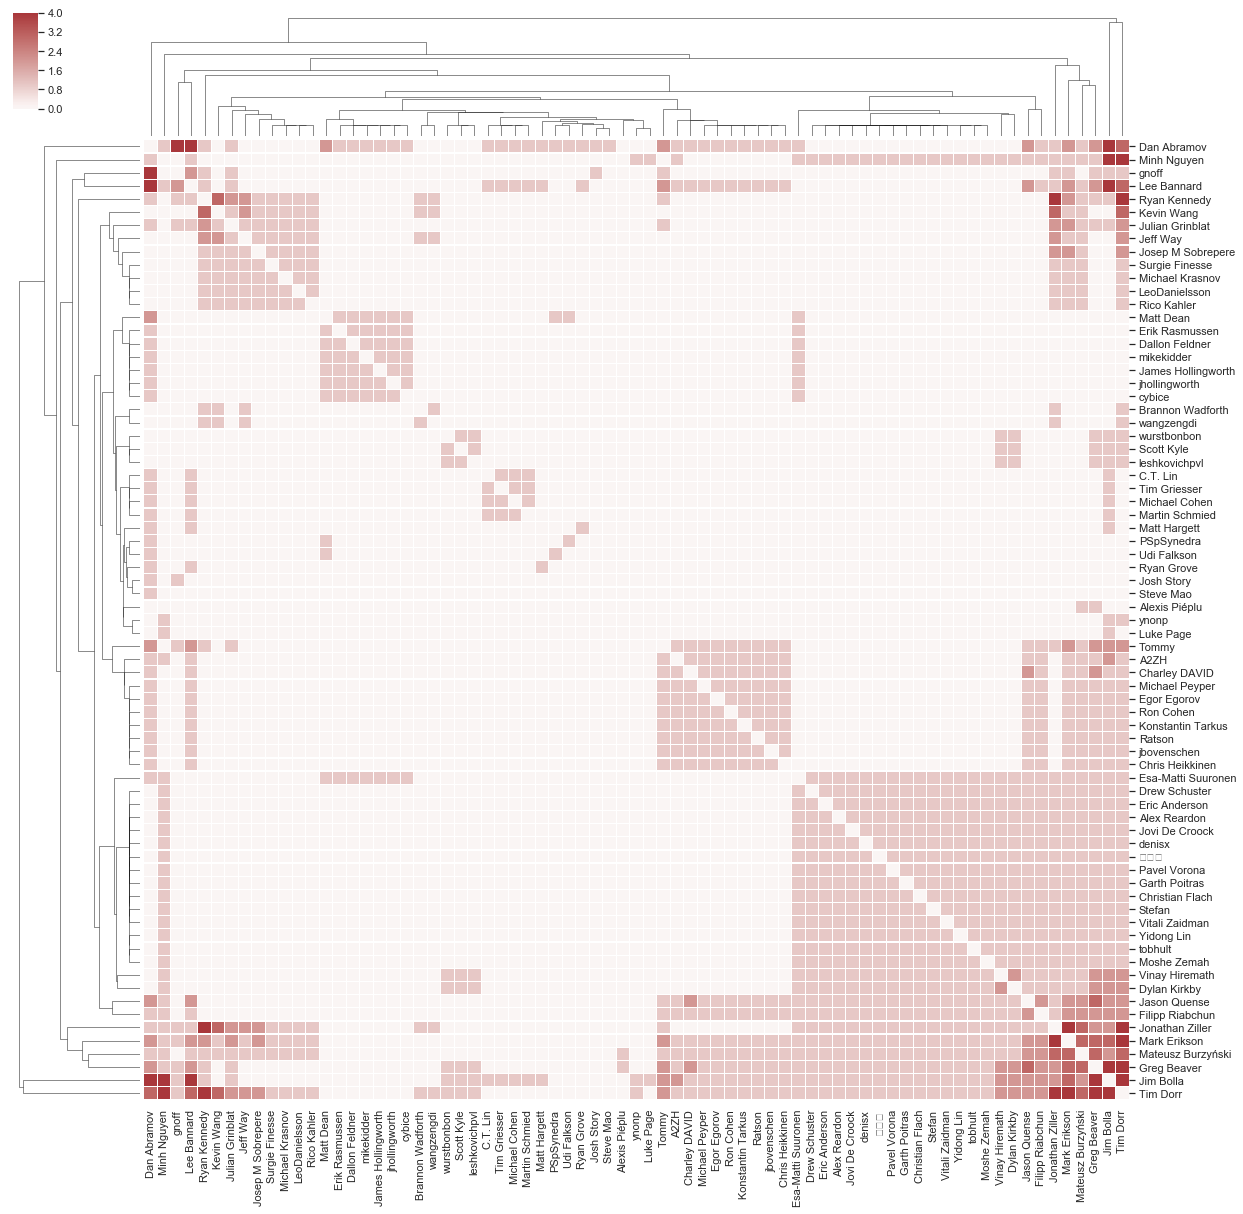

In [18]:
visualize_adjacency_matrix(g)

### Two filtering dimensions: 
- Time interval (or in-between which commits)
- Source code folder

### Node layout: 
- T-sne on co-editing patterns
- Overlap removal
- Node label layout

In [10]:
def tsne_graph(g):
    from networkx.algorithms import shortest_paths
    dist_mat = shortest_paths.dense.floyd_warshall_numpy(g)
    from sklearn import manifold
    tsne = manifold.TSNE(metric='precomputed')
    return tsne.fit_transform(dist_mat)

In [11]:
import altair as alt
import pandas as pd

embedding = tsne_graph(g)
pd = pd.DataFrame(embedding, columns=['x', 'y'])

alt.Chart(pd).mark_point().encode(
    x='x:Q',
    y='y:Q'
)

alt.Chart(...)